In [1]:


from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers import LeakyReLU
from keras.layers import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt
from tqdm import tqdm

import numpy as np

In [2]:
np.random.seed(10)

# The dimension of our random noise vector.
random_dim = 100

In [3]:
def load_minst_data():
    # load the data
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    # normalize our inputs to be in the range[-1, 1]
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    # convert x_train with a shape of (60000, 28, 28) to (60000, 784) so we have
    # 784 columns per row
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)

In [4]:
def get_generator():
    generator = Sequential()
    generator.add(Dense(256, input_dim=random_dim))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(784, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer='rmsprop')
    generator.summary()
    return generator

In [5]:
def get_discriminator():
    discriminator = Sequential()
    discriminator.add(Dense(1024, input_dim=784))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer='rmsprop')

    discriminator.summary()
    return discriminator

In [6]:
def get_gan_network(discriminator, random_dim, generator):
    # We initially set trainable to False since we only want to train either the
    # generator or discriminator at a time
    discriminator.trainable = False
    # gan input (noise) will be 100-dimensional vectors
    gan_input = Input(shape=(random_dim,))
    # the output of the generator (an image)
    x = generator(gan_input)
    # get the output of the discriminator (probability if the image is real or not)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan

In [11]:
def train(epochs=1, batch_size=128):
    # Get the training and testing data
    x_train, y_train, x_test, y_test = load_minst_data()
    # Split the training data into batches of size 128
    batch_count = x_train.shape[0] / batch_size

    # Build our GAN netowrk
    generator = get_generator()
    discriminator = get_discriminator()
    gan = get_gan_network(discriminator, random_dim, generator)

    for e in range(1, epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(int(batch_count))):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

            # Generate fake MNIST images
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])

            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            # One-sided label smoothing
            y_dis[:batch_size] = 0.9

            # Train discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)
            generator.save('generator.h5')

        if e == 1 or e % 20 == 0:
            plot_generated_images(e, generator)

In [12]:
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 256)               25856     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_10 (Dense)            (None, 1024)              525312    
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 1024)              0         
                                                                 
 dense_11 (Dense)            (None, 784)              

  0%|          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 6ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
  0%|          | 1/468 [00:02<16:11,  2.08s/it]

4/4 [==============================] - 0s 8ms/step


  0%|          | 2/468 [00:02<08:37,  1.11s/it]

4/4 [==============================] - 0s 9ms/step


  1%|          | 3/468 [00:02<05:54,  1.31it/s]

4/4 [==============================] - 0s 9ms/step


  1%|          | 4/468 [00:03<04:39,  1.66it/s]

4/4 [==============================] - 0s 8ms/step


  1%|          | 5/468 [00:03<04:09,  1.85it/s]

4/4 [==============================] - 0s 7ms/step


  1%|▏         | 6/468 [00:04<03:41,  2.09it/s]

4/4 [==============================] - 0s 6ms/step


  1%|▏         | 7/468 [00:04<03:09,  2.44it/s]

4/4 [==============================] - 0s 5ms/step


  2%|▏         | 8/468 [00:04<02:43,  2.81it/s]

4/4 [==============================] - 0s 6ms/step


  2%|▏         | 9/468 [00:04<02:30,  3.04it/s]

4/4 [==============================] - 0s 6ms/step


  2%|▏         | 10/468 [00:05<02:21,  3.23it/s]

4/4 [==============================] - 0s 10ms/step


  2%|▏         | 11/468 [00:05<02:14,  3.39it/s]

4/4 [==============================] - 0s 6ms/step


  3%|▎         | 12/468 [00:05<02:06,  3.60it/s]

4/4 [==============================] - 0s 5ms/step


  3%|▎         | 13/468 [00:05<02:06,  3.61it/s]

4/4 [==============================] - 0s 5ms/step


  3%|▎         | 14/468 [00:06<02:04,  3.66it/s]

4/4 [==============================] - 0s 9ms/step


  3%|▎         | 15/468 [00:06<02:02,  3.71it/s]

4/4 [==============================] - 0s 5ms/step


  3%|▎         | 16/468 [00:06<01:57,  3.86it/s]

4/4 [==============================] - 0s 5ms/step


  4%|▎         | 17/468 [00:06<01:58,  3.81it/s]

4/4 [==============================] - 0s 5ms/step


  4%|▍         | 18/468 [00:07<01:55,  3.89it/s]

4/4 [==============================] - 0s 6ms/step


  4%|▍         | 19/468 [00:07<01:58,  3.79it/s]

4/4 [==============================] - 0s 6ms/step


  4%|▍         | 20/468 [00:07<01:55,  3.87it/s]

4/4 [==============================] - 0s 6ms/step


  4%|▍         | 21/468 [00:07<01:56,  3.84it/s]

4/4 [==============================] - 0s 6ms/step


  5%|▍         | 22/468 [00:08<01:56,  3.82it/s]

4/4 [==============================] - 0s 7ms/step


  5%|▍         | 23/468 [00:08<01:54,  3.88it/s]

4/4 [==============================] - 0s 6ms/step


  5%|▌         | 24/468 [00:08<01:56,  3.83it/s]

4/4 [==============================] - 0s 6ms/step


  5%|▌         | 25/468 [00:08<01:51,  3.97it/s]

4/4 [==============================] - 0s 6ms/step


  6%|▌         | 26/468 [00:09<01:49,  4.05it/s]

4/4 [==============================] - 0s 5ms/step


  6%|▌         | 27/468 [00:09<01:49,  4.04it/s]

4/4 [==============================] - 0s 5ms/step


  6%|▌         | 28/468 [00:09<01:47,  4.11it/s]

4/4 [==============================] - 0s 6ms/step


  6%|▌         | 29/468 [00:09<01:50,  3.99it/s]

4/4 [==============================] - 0s 6ms/step


  6%|▋         | 30/468 [00:10<01:49,  4.00it/s]

4/4 [==============================] - 0s 5ms/step


  7%|▋         | 31/468 [00:10<01:48,  4.02it/s]

4/4 [==============================] - 0s 5ms/step


  7%|▋         | 32/468 [00:10<01:50,  3.94it/s]

4/4 [==============================] - 0s 6ms/step


  7%|▋         | 33/468 [00:10<01:52,  3.85it/s]

4/4 [==============================] - 0s 5ms/step


  7%|▋         | 34/468 [00:11<01:54,  3.79it/s]

4/4 [==============================] - 0s 6ms/step


  7%|▋         | 35/468 [00:11<01:56,  3.72it/s]

4/4 [==============================] - 0s 6ms/step


  8%|▊         | 36/468 [00:11<01:52,  3.84it/s]

4/4 [==============================] - 0s 5ms/step


  8%|▊         | 37/468 [00:11<01:54,  3.77it/s]

4/4 [==============================] - 0s 6ms/step


  8%|▊         | 38/468 [00:12<01:55,  3.74it/s]

4/4 [==============================] - 0s 10ms/step


  8%|▊         | 39/468 [00:12<01:55,  3.70it/s]

4/4 [==============================] - 0s 6ms/step


  9%|▊         | 40/468 [00:12<01:56,  3.68it/s]

4/4 [==============================] - 0s 5ms/step


  9%|▉         | 41/468 [00:13<01:56,  3.67it/s]

4/4 [==============================] - 0s 6ms/step


  9%|▉         | 42/468 [00:13<01:52,  3.80it/s]

4/4 [==============================] - 0s 7ms/step


  9%|▉         | 43/468 [00:13<01:53,  3.75it/s]

4/4 [==============================] - 0s 6ms/step


  9%|▉         | 44/468 [00:13<01:52,  3.76it/s]

4/4 [==============================] - 0s 10ms/step


 10%|▉         | 45/468 [00:14<02:00,  3.50it/s]

4/4 [==============================] - 0s 11ms/step


 10%|▉         | 46/468 [00:14<02:12,  3.17it/s]

4/4 [==============================] - 0s 7ms/step


 10%|█         | 47/468 [00:14<02:15,  3.11it/s]

4/4 [==============================] - 0s 8ms/step


 10%|█         | 48/468 [00:15<02:20,  2.98it/s]

4/4 [==============================] - 0s 11ms/step


 10%|█         | 49/468 [00:15<02:27,  2.84it/s]

4/4 [==============================] - 0s 9ms/step


 11%|█         | 50/468 [00:16<02:29,  2.79it/s]

4/4 [==============================] - 0s 6ms/step


 11%|█         | 51/468 [00:16<02:18,  3.01it/s]

4/4 [==============================] - 0s 6ms/step


 11%|█         | 52/468 [00:16<02:12,  3.15it/s]

4/4 [==============================] - 0s 7ms/step


 11%|█▏        | 53/468 [00:16<02:03,  3.36it/s]

4/4 [==============================] - 0s 6ms/step


 12%|█▏        | 54/468 [00:17<02:02,  3.39it/s]

4/4 [==============================] - 0s 7ms/step


 12%|█▏        | 55/468 [00:17<01:59,  3.47it/s]

4/4 [==============================] - 0s 7ms/step


 12%|█▏        | 56/468 [00:17<01:56,  3.53it/s]

4/4 [==============================] - 0s 6ms/step


 12%|█▏        | 57/468 [00:17<01:55,  3.57it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█▏        | 58/468 [00:18<01:55,  3.54it/s]

4/4 [==============================] - 0s 6ms/step


 13%|█▎        | 59/468 [00:18<01:54,  3.58it/s]

4/4 [==============================] - 0s 9ms/step


 13%|█▎        | 60/468 [00:18<01:51,  3.64it/s]

4/4 [==============================] - 0s 6ms/step


 13%|█▎        | 61/468 [00:19<01:47,  3.79it/s]

4/4 [==============================] - 0s 5ms/step


 13%|█▎        | 62/468 [00:19<01:44,  3.89it/s]

4/4 [==============================] - 0s 6ms/step


 13%|█▎        | 63/468 [00:19<01:46,  3.79it/s]

4/4 [==============================] - 0s 8ms/step


 14%|█▎        | 64/468 [00:19<01:47,  3.76it/s]

4/4 [==============================] - 0s 6ms/step


 14%|█▍        | 65/468 [00:20<01:48,  3.72it/s]

4/4 [==============================] - 0s 6ms/step


 14%|█▍        | 66/468 [00:20<01:44,  3.84it/s]

4/4 [==============================] - 0s 6ms/step


 14%|█▍        | 67/468 [00:20<01:42,  3.92it/s]

4/4 [==============================] - 0s 8ms/step


 15%|█▍        | 68/468 [00:20<01:44,  3.84it/s]

4/4 [==============================] - 0s 6ms/step


 15%|█▍        | 69/468 [00:21<01:41,  3.92it/s]

4/4 [==============================] - 0s 6ms/step


 15%|█▍        | 70/468 [00:21<01:43,  3.85it/s]

4/4 [==============================] - 0s 6ms/step


 15%|█▌        | 71/468 [00:21<01:44,  3.78it/s]

4/4 [==============================] - 0s 6ms/step


 15%|█▌        | 72/468 [00:21<01:43,  3.84it/s]

4/4 [==============================] - 0s 6ms/step


 16%|█▌        | 73/468 [00:22<01:41,  3.90it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█▌        | 74/468 [00:22<01:39,  3.97it/s]

4/4 [==============================] - 0s 6ms/step


 16%|█▌        | 75/468 [00:22<01:37,  4.04it/s]

4/4 [==============================] - 0s 6ms/step


 16%|█▌        | 76/468 [00:22<01:42,  3.84it/s]

4/4 [==============================] - 0s 6ms/step


 16%|█▋        | 77/468 [00:23<01:44,  3.74it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█▋        | 78/468 [00:23<01:44,  3.74it/s]

4/4 [==============================] - 0s 6ms/step


 17%|█▋        | 79/468 [00:23<01:40,  3.85it/s]

4/4 [==============================] - 0s 6ms/step


 17%|█▋        | 80/468 [00:23<01:43,  3.74it/s]

4/4 [==============================] - 0s 6ms/step


 17%|█▋        | 81/468 [00:24<01:44,  3.71it/s]

4/4 [==============================] - 0s 6ms/step


 18%|█▊        | 82/468 [00:24<01:44,  3.68it/s]

4/4 [==============================] - 0s 5ms/step


 18%|█▊        | 83/468 [00:24<01:45,  3.65it/s]

4/4 [==============================] - 0s 6ms/step


 18%|█▊        | 84/468 [00:25<01:45,  3.63it/s]

4/4 [==============================] - 0s 6ms/step


 18%|█▊        | 85/468 [00:25<01:45,  3.64it/s]

4/4 [==============================] - 0s 6ms/step


 18%|█▊        | 86/468 [00:25<01:40,  3.79it/s]

4/4 [==============================] - 0s 6ms/step


 19%|█▊        | 87/468 [00:25<01:40,  3.78it/s]

4/4 [==============================] - 0s 6ms/step


 19%|█▉        | 88/468 [00:26<01:42,  3.69it/s]

4/4 [==============================] - 0s 10ms/step


 19%|█▉        | 89/468 [00:26<01:52,  3.36it/s]

4/4 [==============================] - 0s 7ms/step


 19%|█▉        | 90/468 [00:26<02:03,  3.07it/s]

4/4 [==============================] - 0s 8ms/step


 19%|█▉        | 91/468 [00:27<02:08,  2.92it/s]

4/4 [==============================] - 0s 10ms/step


 20%|█▉        | 92/468 [00:27<02:09,  2.90it/s]

4/4 [==============================] - 0s 9ms/step


 20%|█▉        | 93/468 [00:28<02:15,  2.78it/s]

4/4 [==============================] - 0s 9ms/step


 20%|██        | 94/468 [00:28<02:08,  2.91it/s]

4/4 [==============================] - 0s 6ms/step


 20%|██        | 95/468 [00:28<01:56,  3.20it/s]

4/4 [==============================] - 0s 6ms/step


 21%|██        | 96/468 [00:28<01:47,  3.45it/s]

4/4 [==============================] - 0s 6ms/step


 21%|██        | 97/468 [00:29<01:46,  3.48it/s]

4/4 [==============================] - 0s 7ms/step


 21%|██        | 98/468 [00:29<01:45,  3.50it/s]

4/4 [==============================] - 0s 5ms/step


 21%|██        | 99/468 [00:29<01:43,  3.55it/s]

4/4 [==============================] - 0s 6ms/step


 21%|██▏       | 100/468 [00:29<01:41,  3.61it/s]

4/4 [==============================] - 0s 5ms/step


 22%|██▏       | 101/468 [00:30<01:39,  3.69it/s]

4/4 [==============================] - 0s 6ms/step


 22%|██▏       | 102/468 [00:30<01:35,  3.84it/s]

4/4 [==============================] - 0s 6ms/step


 22%|██▏       | 103/468 [00:30<01:33,  3.88it/s]

4/4 [==============================] - 0s 6ms/step


 22%|██▏       | 104/468 [00:30<01:33,  3.91it/s]

4/4 [==============================] - 0s 12ms/step


 22%|██▏       | 105/468 [00:31<01:33,  3.86it/s]

4/4 [==============================] - 0s 6ms/step


 23%|██▎       | 106/468 [00:31<01:34,  3.82it/s]

4/4 [==============================] - 0s 6ms/step


 23%|██▎       | 107/468 [00:31<01:32,  3.90it/s]

4/4 [==============================] - 0s 6ms/step


 23%|██▎       | 108/468 [00:31<01:32,  3.91it/s]

4/4 [==============================] - 0s 9ms/step


 23%|██▎       | 109/468 [00:32<01:32,  3.88it/s]

4/4 [==============================] - 0s 6ms/step


 24%|██▎       | 110/468 [00:32<01:33,  3.84it/s]

4/4 [==============================] - 0s 6ms/step


 24%|██▎       | 111/468 [00:32<01:33,  3.80it/s]

4/4 [==============================] - 0s 6ms/step


 24%|██▍       | 112/468 [00:32<01:31,  3.91it/s]

4/4 [==============================] - 0s 10ms/step


 24%|██▍       | 113/468 [00:33<01:32,  3.84it/s]

4/4 [==============================] - 0s 6ms/step


 24%|██▍       | 114/468 [00:33<01:30,  3.93it/s]

4/4 [==============================] - 0s 7ms/step


 25%|██▍       | 115/468 [00:33<01:27,  4.01it/s]

4/4 [==============================] - 0s 7ms/step


 25%|██▍       | 116/468 [00:33<01:27,  4.03it/s]

4/4 [==============================] - 0s 6ms/step


 25%|██▌       | 117/468 [00:34<01:28,  3.99it/s]

4/4 [==============================] - 0s 6ms/step


 25%|██▌       | 118/468 [00:34<01:26,  4.02it/s]

4/4 [==============================] - 0s 7ms/step


 25%|██▌       | 119/468 [00:34<01:28,  3.93it/s]

4/4 [==============================] - 0s 6ms/step


 26%|██▌       | 120/468 [00:34<01:27,  3.98it/s]

4/4 [==============================] - 0s 6ms/step


 26%|██▌       | 121/468 [00:35<01:27,  3.97it/s]

4/4 [==============================] - 0s 6ms/step


 26%|██▌       | 122/468 [00:35<01:26,  3.99it/s]

4/4 [==============================] - 0s 9ms/step


 26%|██▋       | 123/468 [00:35<01:26,  3.97it/s]

4/4 [==============================] - 0s 6ms/step


 26%|██▋       | 124/468 [00:36<01:30,  3.82it/s]

4/4 [==============================] - 0s 6ms/step


 27%|██▋       | 125/468 [00:36<01:29,  3.81it/s]

4/4 [==============================] - 0s 6ms/step


 27%|██▋       | 126/468 [00:36<01:27,  3.91it/s]

4/4 [==============================] - 0s 6ms/step


 27%|██▋       | 127/468 [00:36<01:26,  3.95it/s]

4/4 [==============================] - 0s 6ms/step


 27%|██▋       | 128/468 [00:37<01:27,  3.86it/s]

4/4 [==============================] - 0s 7ms/step


 28%|██▊       | 129/468 [00:37<01:28,  3.84it/s]

4/4 [==============================] - 0s 6ms/step


 28%|██▊       | 130/468 [00:37<01:25,  3.93it/s]

4/4 [==============================] - 0s 6ms/step


 28%|██▊       | 131/468 [00:37<01:25,  3.96it/s]

4/4 [==============================] - 0s 6ms/step


 28%|██▊       | 132/468 [00:38<01:25,  3.94it/s]

4/4 [==============================] - 0s 6ms/step


 28%|██▊       | 133/468 [00:38<01:36,  3.47it/s]

4/4 [==============================] - 0s 7ms/step


 29%|██▊       | 134/468 [00:38<01:46,  3.14it/s]

4/4 [==============================] - 0s 9ms/step


 29%|██▉       | 135/468 [00:39<01:56,  2.85it/s]

4/4 [==============================] - 0s 10ms/step


 29%|██▉       | 136/468 [00:39<02:00,  2.76it/s]

4/4 [==============================] - 0s 9ms/step


 29%|██▉       | 137/468 [00:40<02:08,  2.59it/s]

4/4 [==============================] - 0s 7ms/step


 29%|██▉       | 138/468 [00:40<02:00,  2.73it/s]

4/4 [==============================] - 0s 6ms/step


 30%|██▉       | 139/468 [00:40<01:47,  3.05it/s]

4/4 [==============================] - 0s 6ms/step


 30%|██▉       | 140/468 [00:40<01:38,  3.32it/s]

4/4 [==============================] - 0s 6ms/step


 30%|███       | 141/468 [00:41<01:32,  3.52it/s]

4/4 [==============================] - 0s 7ms/step


 30%|███       | 142/468 [00:41<01:31,  3.56it/s]

4/4 [==============================] - 0s 6ms/step


 31%|███       | 143/468 [00:41<01:31,  3.56it/s]

4/4 [==============================] - 0s 6ms/step


 31%|███       | 144/468 [00:41<01:27,  3.71it/s]

4/4 [==============================] - 0s 6ms/step


 31%|███       | 145/468 [00:42<01:27,  3.70it/s]

4/4 [==============================] - 0s 6ms/step


 31%|███       | 146/468 [00:42<01:26,  3.72it/s]

4/4 [==============================] - 0s 6ms/step


 31%|███▏      | 147/468 [00:42<01:28,  3.65it/s]

4/4 [==============================] - 0s 6ms/step


 32%|███▏      | 148/468 [00:42<01:25,  3.75it/s]

4/4 [==============================] - 0s 6ms/step


 32%|███▏      | 149/468 [00:43<01:26,  3.69it/s]

4/4 [==============================] - 0s 6ms/step


 32%|███▏      | 150/468 [00:43<01:24,  3.78it/s]

4/4 [==============================] - 0s 6ms/step


 32%|███▏      | 151/468 [00:43<01:24,  3.76it/s]

4/4 [==============================] - 0s 6ms/step


 32%|███▏      | 152/468 [00:44<01:23,  3.77it/s]

4/4 [==============================] - 0s 6ms/step


 33%|███▎      | 153/468 [00:44<01:24,  3.73it/s]

4/4 [==============================] - 0s 6ms/step


 33%|███▎      | 154/468 [00:44<01:22,  3.79it/s]

4/4 [==============================] - 0s 6ms/step


 33%|███▎      | 155/468 [00:44<01:23,  3.75it/s]

4/4 [==============================] - 0s 7ms/step


 33%|███▎      | 156/468 [00:45<01:22,  3.80it/s]

4/4 [==============================] - 0s 6ms/step


 34%|███▎      | 157/468 [00:45<01:21,  3.81it/s]

4/4 [==============================] - 0s 6ms/step


 34%|███▍      | 158/468 [00:45<01:23,  3.71it/s]

4/4 [==============================] - 0s 6ms/step


 34%|███▍      | 159/468 [00:45<01:22,  3.74it/s]

4/4 [==============================] - 0s 6ms/step


 34%|███▍      | 160/468 [00:46<01:20,  3.82it/s]

4/4 [==============================] - 0s 6ms/step


 34%|███▍      | 161/468 [00:46<01:21,  3.74it/s]

4/4 [==============================] - 0s 6ms/step


 35%|███▍      | 162/468 [00:46<01:22,  3.72it/s]

4/4 [==============================] - 0s 6ms/step


 35%|███▍      | 163/468 [00:47<01:22,  3.68it/s]

4/4 [==============================] - 0s 7ms/step


 35%|███▌      | 164/468 [00:47<01:22,  3.67it/s]

4/4 [==============================] - 0s 7ms/step


 35%|███▌      | 165/468 [00:47<01:23,  3.64it/s]

4/4 [==============================] - 0s 6ms/step


 35%|███▌      | 166/468 [00:47<01:24,  3.56it/s]

4/4 [==============================] - 0s 6ms/step


 36%|███▌      | 167/468 [00:48<01:24,  3.58it/s]

4/4 [==============================] - 0s 7ms/step


 36%|███▌      | 168/468 [00:48<01:24,  3.55it/s]

4/4 [==============================] - 0s 6ms/step


 36%|███▌      | 169/468 [00:48<01:24,  3.53it/s]

4/4 [==============================] - 0s 7ms/step


 36%|███▋      | 170/468 [00:48<01:22,  3.60it/s]

4/4 [==============================] - 0s 6ms/step


 37%|███▋      | 171/468 [00:49<01:21,  3.64it/s]

4/4 [==============================] - 0s 6ms/step


 37%|███▋      | 172/468 [00:49<01:20,  3.67it/s]

4/4 [==============================] - 0s 6ms/step


 37%|███▋      | 173/468 [00:49<01:21,  3.63it/s]

4/4 [==============================] - 0s 6ms/step


 37%|███▋      | 174/468 [00:50<01:20,  3.66it/s]

4/4 [==============================] - 0s 7ms/step


 37%|███▋      | 175/468 [00:50<01:27,  3.34it/s]

4/4 [==============================] - 0s 8ms/step


 38%|███▊      | 176/468 [00:50<01:35,  3.06it/s]

4/4 [==============================] - 0s 11ms/step


 38%|███▊      | 177/468 [00:51<01:38,  2.96it/s]

4/4 [==============================] - 0s 9ms/step


 38%|███▊      | 178/468 [00:51<01:39,  2.93it/s]

4/4 [==============================] - 0s 10ms/step


 38%|███▊      | 179/468 [00:51<01:42,  2.81it/s]

4/4 [==============================] - 0s 10ms/step


 38%|███▊      | 180/468 [00:52<01:43,  2.78it/s]

4/4 [==============================] - 0s 6ms/step


 39%|███▊      | 181/468 [00:52<01:33,  3.08it/s]

4/4 [==============================] - 0s 6ms/step


 39%|███▉      | 182/468 [00:52<01:25,  3.33it/s]

4/4 [==============================] - 0s 6ms/step


 39%|███▉      | 183/468 [00:53<01:21,  3.48it/s]

4/4 [==============================] - 0s 6ms/step


 39%|███▉      | 184/468 [00:53<01:20,  3.53it/s]

4/4 [==============================] - 0s 6ms/step


 40%|███▉      | 185/468 [00:53<01:20,  3.49it/s]

4/4 [==============================] - 0s 6ms/step


 40%|███▉      | 186/468 [00:53<01:20,  3.49it/s]

4/4 [==============================] - 0s 6ms/step


 40%|███▉      | 187/468 [00:54<01:19,  3.54it/s]

4/4 [==============================] - 0s 6ms/step


 40%|████      | 188/468 [00:54<01:15,  3.70it/s]

4/4 [==============================] - 0s 6ms/step


 40%|████      | 189/468 [00:54<01:12,  3.83it/s]

4/4 [==============================] - 0s 6ms/step


 41%|████      | 190/468 [00:54<01:11,  3.87it/s]

4/4 [==============================] - 0s 6ms/step


 41%|████      | 191/468 [00:55<01:10,  3.94it/s]

4/4 [==============================] - 0s 6ms/step


 41%|████      | 192/468 [00:55<01:11,  3.85it/s]

4/4 [==============================] - 0s 6ms/step


 41%|████      | 193/468 [00:55<01:09,  3.93it/s]

4/4 [==============================] - 0s 7ms/step


 41%|████▏     | 194/468 [00:55<01:12,  3.79it/s]

4/4 [==============================] - 0s 7ms/step


 42%|████▏     | 195/468 [00:56<01:10,  3.85it/s]

4/4 [==============================] - 0s 6ms/step


 42%|████▏     | 196/468 [00:56<01:09,  3.94it/s]

4/4 [==============================] - 0s 7ms/step


 42%|████▏     | 197/468 [00:56<01:08,  3.96it/s]

4/4 [==============================] - 0s 6ms/step


 42%|████▏     | 198/468 [00:56<01:09,  3.89it/s]

4/4 [==============================] - 0s 8ms/step


 43%|████▎     | 199/468 [00:57<01:11,  3.79it/s]

4/4 [==============================] - 0s 7ms/step


 43%|████▎     | 200/468 [00:57<01:11,  3.75it/s]

4/4 [==============================] - 0s 6ms/step


 43%|████▎     | 201/468 [00:57<01:09,  3.83it/s]

4/4 [==============================] - 0s 6ms/step


 43%|████▎     | 202/468 [00:57<01:08,  3.86it/s]

4/4 [==============================] - 0s 6ms/step


 43%|████▎     | 203/468 [00:58<01:10,  3.78it/s]

4/4 [==============================] - 0s 6ms/step


 44%|████▎     | 204/468 [00:58<01:10,  3.73it/s]

4/4 [==============================] - 0s 7ms/step


 44%|████▍     | 205/468 [00:58<01:11,  3.70it/s]

4/4 [==============================] - 0s 6ms/step


 44%|████▍     | 206/468 [00:59<01:10,  3.74it/s]

4/4 [==============================] - 0s 6ms/step


 44%|████▍     | 207/468 [00:59<01:08,  3.81it/s]

4/4 [==============================] - 0s 7ms/step


 44%|████▍     | 208/468 [00:59<01:06,  3.91it/s]

4/4 [==============================] - 0s 7ms/step


 45%|████▍     | 209/468 [00:59<01:07,  3.81it/s]

4/4 [==============================] - 0s 8ms/step


 45%|████▍     | 210/468 [01:00<01:08,  3.77it/s]

4/4 [==============================] - 0s 7ms/step


 45%|████▌     | 211/468 [01:00<01:08,  3.73it/s]

4/4 [==============================] - 0s 7ms/step


 45%|████▌     | 212/468 [01:00<01:06,  3.82it/s]

4/4 [==============================] - 0s 6ms/step


 46%|████▌     | 213/468 [01:00<01:07,  3.77it/s]

4/4 [==============================] - 0s 6ms/step


 46%|████▌     | 214/468 [01:01<01:07,  3.76it/s]

4/4 [==============================] - 0s 6ms/step


 46%|████▌     | 215/468 [01:01<01:05,  3.87it/s]

4/4 [==============================] - 0s 7ms/step


 46%|████▌     | 216/468 [01:01<01:04,  3.92it/s]

4/4 [==============================] - 0s 7ms/step


 46%|████▋     | 217/468 [01:01<01:06,  3.75it/s]

4/4 [==============================] - 0s 6ms/step


 47%|████▋     | 218/468 [01:02<01:07,  3.69it/s]

4/4 [==============================] - 0s 9ms/step


 47%|████▋     | 219/468 [01:02<01:16,  3.26it/s]

4/4 [==============================] - 0s 11ms/step


 47%|████▋     | 220/468 [01:03<01:20,  3.07it/s]

4/4 [==============================] - 0s 19ms/step


 47%|████▋     | 221/468 [01:04<02:12,  1.86it/s]

4/4 [==============================] - 0s 11ms/step


 47%|████▋     | 222/468 [01:04<02:33,  1.61it/s]

4/4 [==============================] - 0s 6ms/step


 48%|████▊     | 223/468 [01:05<02:27,  1.66it/s]

4/4 [==============================] - 0s 6ms/step


 48%|████▊     | 224/468 [01:05<02:01,  2.01it/s]

4/4 [==============================] - 0s 7ms/step


 48%|████▊     | 225/468 [01:05<01:44,  2.32it/s]

4/4 [==============================] - 0s 7ms/step


 48%|████▊     | 226/468 [01:06<01:30,  2.67it/s]

4/4 [==============================] - 0s 6ms/step


 49%|████▊     | 227/468 [01:06<01:23,  2.89it/s]

4/4 [==============================] - 0s 6ms/step


 49%|████▊     | 228/468 [01:06<01:17,  3.10it/s]

4/4 [==============================] - 0s 6ms/step


 49%|████▉     | 229/468 [01:06<01:11,  3.34it/s]

4/4 [==============================] - 0s 6ms/step


 49%|████▉     | 230/468 [01:07<01:09,  3.44it/s]

4/4 [==============================] - 0s 10ms/step


 49%|████▉     | 231/468 [01:07<01:08,  3.46it/s]

4/4 [==============================] - 0s 6ms/step


 50%|████▉     | 232/468 [01:07<01:07,  3.52it/s]

4/4 [==============================] - 0s 7ms/step


 50%|████▉     | 233/468 [01:08<01:05,  3.56it/s]

4/4 [==============================] - 0s 6ms/step


 50%|█████     | 234/468 [01:08<01:05,  3.57it/s]

4/4 [==============================] - 0s 6ms/step


 50%|█████     | 235/468 [01:08<01:03,  3.66it/s]

4/4 [==============================] - 0s 7ms/step


 50%|█████     | 236/468 [01:08<01:01,  3.77it/s]

4/4 [==============================] - 0s 7ms/step


 51%|█████     | 237/468 [01:09<01:01,  3.75it/s]

4/4 [==============================] - 0s 6ms/step


 51%|█████     | 238/468 [01:09<00:59,  3.86it/s]

4/4 [==============================] - 0s 6ms/step


 51%|█████     | 239/468 [01:09<01:01,  3.72it/s]

4/4 [==============================] - 0s 7ms/step


 51%|█████▏    | 240/468 [01:09<01:02,  3.66it/s]

4/4 [==============================] - 0s 6ms/step


 51%|█████▏    | 241/468 [01:10<01:00,  3.78it/s]

4/4 [==============================] - 0s 6ms/step


 52%|█████▏    | 242/468 [01:10<01:01,  3.69it/s]

4/4 [==============================] - 0s 6ms/step


 52%|█████▏    | 243/468 [01:10<00:58,  3.82it/s]

4/4 [==============================] - 0s 6ms/step


 52%|█████▏    | 244/468 [01:10<00:59,  3.75it/s]

4/4 [==============================] - 0s 7ms/step


 52%|█████▏    | 245/468 [01:11<01:00,  3.70it/s]

4/4 [==============================] - 0s 6ms/step


 53%|█████▎    | 246/468 [01:11<00:59,  3.76it/s]

4/4 [==============================] - 0s 6ms/step


 53%|█████▎    | 247/468 [01:11<00:57,  3.83it/s]

4/4 [==============================] - 0s 6ms/step


 53%|█████▎    | 248/468 [01:12<00:55,  3.94it/s]

4/4 [==============================] - 0s 7ms/step


 53%|█████▎    | 249/468 [01:12<00:56,  3.87it/s]

4/4 [==============================] - 0s 6ms/step


 53%|█████▎    | 250/468 [01:12<00:58,  3.75it/s]

4/4 [==============================] - 0s 7ms/step


 54%|█████▎    | 251/468 [01:12<00:57,  3.78it/s]

4/4 [==============================] - 0s 7ms/step


 54%|█████▍    | 252/468 [01:13<00:57,  3.74it/s]

4/4 [==============================] - 0s 6ms/step


 54%|█████▍    | 253/468 [01:13<00:56,  3.80it/s]

4/4 [==============================] - 0s 6ms/step


 54%|█████▍    | 254/468 [01:13<00:56,  3.80it/s]

4/4 [==============================] - 0s 6ms/step


 54%|█████▍    | 255/468 [01:13<00:56,  3.74it/s]

4/4 [==============================] - 0s 6ms/step


 55%|█████▍    | 256/468 [01:14<00:55,  3.82it/s]

4/4 [==============================] - 0s 6ms/step


 55%|█████▍    | 257/468 [01:14<00:53,  3.92it/s]

4/4 [==============================] - 0s 6ms/step


 55%|█████▌    | 258/468 [01:14<00:58,  3.59it/s]

4/4 [==============================] - 0s 12ms/step


 55%|█████▌    | 259/468 [01:15<01:03,  3.29it/s]

4/4 [==============================] - 0s 8ms/step


 56%|█████▌    | 260/468 [01:15<01:08,  3.04it/s]

4/4 [==============================] - 0s 8ms/step


 56%|█████▌    | 261/468 [01:15<01:15,  2.75it/s]

4/4 [==============================] - 0s 9ms/step


 56%|█████▌    | 262/468 [01:16<01:16,  2.71it/s]

4/4 [==============================] - 0s 9ms/step


 56%|█████▌    | 263/468 [01:16<01:14,  2.76it/s]

4/4 [==============================] - 0s 6ms/step


 56%|█████▋    | 264/468 [01:16<01:09,  2.95it/s]

4/4 [==============================] - 0s 7ms/step


 57%|█████▋    | 265/468 [01:17<01:05,  3.12it/s]

4/4 [==============================] - 0s 6ms/step


 57%|█████▋    | 266/468 [01:17<01:02,  3.24it/s]

4/4 [==============================] - 0s 10ms/step


 57%|█████▋    | 267/468 [01:17<01:00,  3.35it/s]

4/4 [==============================] - 0s 6ms/step


 57%|█████▋    | 268/468 [01:18<00:56,  3.51it/s]

4/4 [==============================] - 0s 7ms/step


 57%|█████▋    | 269/468 [01:18<00:54,  3.68it/s]

4/4 [==============================] - 0s 7ms/step


 58%|█████▊    | 270/468 [01:18<00:54,  3.63it/s]

4/4 [==============================] - 0s 7ms/step


 58%|█████▊    | 271/468 [01:18<00:54,  3.60it/s]

4/4 [==============================] - 0s 7ms/step


 58%|█████▊    | 272/468 [01:19<00:54,  3.62it/s]

4/4 [==============================] - 0s 6ms/step


 58%|█████▊    | 273/468 [01:19<00:55,  3.51it/s]

4/4 [==============================] - 0s 8ms/step


 59%|█████▊    | 274/468 [01:19<00:54,  3.54it/s]

4/4 [==============================] - 0s 8ms/step


 59%|█████▉    | 275/468 [01:19<00:54,  3.55it/s]

4/4 [==============================] - 0s 6ms/step


 59%|█████▉    | 276/468 [01:20<00:52,  3.67it/s]

4/4 [==============================] - 0s 7ms/step


 59%|█████▉    | 277/468 [01:20<00:50,  3.76it/s]

4/4 [==============================] - 0s 6ms/step


 59%|█████▉    | 278/468 [01:20<00:51,  3.66it/s]

4/4 [==============================] - 0s 6ms/step


 60%|█████▉    | 279/468 [01:21<00:52,  3.60it/s]

4/4 [==============================] - 0s 7ms/step


 60%|█████▉    | 280/468 [01:21<00:52,  3.60it/s]

4/4 [==============================] - 0s 6ms/step


 60%|██████    | 281/468 [01:21<01:09,  2.68it/s]

4/4 [==============================] - 0s 6ms/step


 60%|██████    | 282/468 [01:22<01:09,  2.66it/s]

4/4 [==============================] - 0s 6ms/step


 60%|██████    | 283/468 [01:22<01:02,  2.94it/s]

4/4 [==============================] - 0s 19ms/step


 61%|██████    | 284/468 [01:23<01:20,  2.28it/s]

4/4 [==============================] - 0s 6ms/step


 61%|██████    | 285/468 [01:23<01:12,  2.53it/s]

4/4 [==============================] - 0s 6ms/step


 61%|██████    | 286/468 [01:23<01:05,  2.78it/s]

4/4 [==============================] - 0s 6ms/step


 61%|██████▏   | 287/468 [01:24<00:59,  3.04it/s]

4/4 [==============================] - 0s 6ms/step


 62%|██████▏   | 288/468 [01:24<00:56,  3.19it/s]

4/4 [==============================] - 0s 7ms/step


 62%|██████▏   | 289/468 [01:24<00:53,  3.36it/s]

4/4 [==============================] - 0s 6ms/step


 62%|██████▏   | 290/468 [01:24<00:49,  3.57it/s]

4/4 [==============================] - 0s 6ms/step


 62%|██████▏   | 291/468 [01:25<00:49,  3.59it/s]

4/4 [==============================] - 0s 7ms/step


 62%|██████▏   | 292/468 [01:25<00:48,  3.64it/s]

4/4 [==============================] - 0s 7ms/step


 63%|██████▎   | 293/468 [01:25<00:46,  3.74it/s]

4/4 [==============================] - 0s 6ms/step


 63%|██████▎   | 294/468 [01:25<00:47,  3.69it/s]

4/4 [==============================] - 0s 7ms/step


 63%|██████▎   | 295/468 [01:26<00:47,  3.63it/s]

4/4 [==============================] - 0s 7ms/step


 63%|██████▎   | 296/468 [01:26<00:47,  3.63it/s]

4/4 [==============================] - 0s 10ms/step


 63%|██████▎   | 297/468 [01:26<00:50,  3.40it/s]

4/4 [==============================] - 0s 9ms/step


 64%|██████▎   | 298/468 [01:27<00:54,  3.13it/s]

4/4 [==============================] - 0s 8ms/step


 64%|██████▍   | 299/468 [01:27<00:56,  2.97it/s]

4/4 [==============================] - 0s 10ms/step


 64%|██████▍   | 300/468 [01:27<01:01,  2.75it/s]

4/4 [==============================] - 0s 12ms/step


 64%|██████▍   | 301/468 [01:28<01:06,  2.51it/s]

4/4 [==============================] - 0s 6ms/step


 65%|██████▍   | 302/468 [01:28<01:01,  2.69it/s]

4/4 [==============================] - 0s 6ms/step


 65%|██████▍   | 303/468 [01:29<00:56,  2.93it/s]

4/4 [==============================] - 0s 9ms/step


 65%|██████▍   | 304/468 [01:29<00:52,  3.13it/s]

4/4 [==============================] - 0s 6ms/step


 65%|██████▌   | 305/468 [01:29<00:49,  3.30it/s]

4/4 [==============================] - 0s 7ms/step


 65%|██████▌   | 306/468 [01:29<00:48,  3.36it/s]

4/4 [==============================] - 0s 6ms/step


 66%|██████▌   | 307/468 [01:30<00:46,  3.45it/s]

4/4 [==============================] - 0s 6ms/step


 66%|██████▌   | 308/468 [01:30<00:44,  3.57it/s]

4/4 [==============================] - 0s 7ms/step


 66%|██████▌   | 309/468 [01:30<00:44,  3.59it/s]

4/4 [==============================] - 0s 6ms/step


 66%|██████▌   | 310/468 [01:30<00:43,  3.62it/s]

4/4 [==============================] - 0s 6ms/step


 66%|██████▋   | 311/468 [01:31<00:44,  3.56it/s]

4/4 [==============================] - 0s 7ms/step


 67%|██████▋   | 312/468 [01:31<00:44,  3.53it/s]

4/4 [==============================] - 0s 6ms/step


 67%|██████▋   | 313/468 [01:31<00:42,  3.62it/s]

4/4 [==============================] - 0s 6ms/step


 67%|██████▋   | 314/468 [01:32<00:41,  3.72it/s]

4/4 [==============================] - 0s 7ms/step


 67%|██████▋   | 315/468 [01:32<00:41,  3.72it/s]

4/4 [==============================] - 0s 6ms/step


 68%|██████▊   | 316/468 [01:32<00:39,  3.80it/s]

4/4 [==============================] - 0s 7ms/step


 68%|██████▊   | 317/468 [01:32<00:40,  3.73it/s]

4/4 [==============================] - 0s 7ms/step


 68%|██████▊   | 318/468 [01:33<00:39,  3.81it/s]

4/4 [==============================] - 0s 6ms/step


 68%|██████▊   | 319/468 [01:33<00:40,  3.70it/s]

4/4 [==============================] - 0s 6ms/step


 68%|██████▊   | 320/468 [01:33<00:40,  3.70it/s]

4/4 [==============================] - 0s 7ms/step


 69%|██████▊   | 321/468 [01:33<00:39,  3.70it/s]

4/4 [==============================] - 0s 6ms/step


 69%|██████▉   | 322/468 [01:34<00:40,  3.60it/s]

4/4 [==============================] - 0s 10ms/step


 69%|██████▉   | 323/468 [01:34<00:40,  3.59it/s]

4/4 [==============================] - 0s 7ms/step


 69%|██████▉   | 324/468 [01:34<00:39,  3.67it/s]

4/4 [==============================] - 0s 6ms/step


 69%|██████▉   | 325/468 [01:34<00:38,  3.76it/s]

4/4 [==============================] - 0s 6ms/step


 70%|██████▉   | 326/468 [01:35<00:37,  3.75it/s]

4/4 [==============================] - 0s 10ms/step


 70%|██████▉   | 327/468 [01:35<00:37,  3.71it/s]

4/4 [==============================] - 0s 7ms/step


 70%|███████   | 328/468 [01:35<00:37,  3.76it/s]

4/4 [==============================] - 0s 8ms/step


 70%|███████   | 329/468 [01:36<00:37,  3.71it/s]

4/4 [==============================] - 0s 7ms/step


 71%|███████   | 330/468 [01:36<00:37,  3.71it/s]

4/4 [==============================] - 0s 7ms/step


 71%|███████   | 331/468 [01:36<00:36,  3.77it/s]

4/4 [==============================] - 0s 7ms/step


 71%|███████   | 332/468 [01:36<00:35,  3.82it/s]

4/4 [==============================] - 0s 8ms/step


 71%|███████   | 333/468 [01:37<00:35,  3.79it/s]

4/4 [==============================] - 0s 6ms/step


 71%|███████▏  | 334/468 [01:37<00:34,  3.86it/s]

4/4 [==============================] - 0s 7ms/step


 72%|███████▏  | 335/468 [01:37<00:35,  3.75it/s]

4/4 [==============================] - 0s 6ms/step


 72%|███████▏  | 336/468 [01:37<00:34,  3.83it/s]

4/4 [==============================] - 0s 6ms/step


 72%|███████▏  | 337/468 [01:38<00:34,  3.76it/s]

4/4 [==============================] - 0s 7ms/step


 72%|███████▏  | 338/468 [01:38<00:35,  3.71it/s]

4/4 [==============================] - 0s 6ms/step


 72%|███████▏  | 339/468 [01:38<00:38,  3.39it/s]

4/4 [==============================] - 0s 11ms/step


 73%|███████▎  | 340/468 [01:39<00:41,  3.07it/s]

4/4 [==============================] - 0s 10ms/step


 73%|███████▎  | 341/468 [01:39<00:44,  2.84it/s]

4/4 [==============================] - 0s 10ms/step


 73%|███████▎  | 342/468 [01:40<01:08,  1.83it/s]

4/4 [==============================] - 0s 6ms/step


 73%|███████▎  | 343/468 [01:40<00:58,  2.15it/s]

4/4 [==============================] - 0s 7ms/step


 74%|███████▎  | 344/468 [01:41<00:49,  2.49it/s]

4/4 [==============================] - 0s 6ms/step


 74%|███████▎  | 345/468 [01:41<00:43,  2.80it/s]

4/4 [==============================] - 0s 6ms/step


 74%|███████▍  | 346/468 [01:41<00:40,  3.05it/s]

4/4 [==============================] - 0s 6ms/step


 74%|███████▍  | 347/468 [01:41<00:37,  3.19it/s]

4/4 [==============================] - 0s 7ms/step


 74%|███████▍  | 348/468 [01:42<00:36,  3.30it/s]

4/4 [==============================] - 0s 6ms/step


 75%|███████▍  | 349/468 [01:42<00:35,  3.39it/s]

4/4 [==============================] - 0s 6ms/step


 75%|███████▍  | 350/468 [01:42<00:35,  3.36it/s]

4/4 [==============================] - 0s 7ms/step


 75%|███████▌  | 351/468 [01:43<00:33,  3.50it/s]

4/4 [==============================] - 0s 8ms/step


 75%|███████▌  | 352/468 [01:43<00:32,  3.60it/s]

4/4 [==============================] - 0s 6ms/step


 75%|███████▌  | 353/468 [01:43<00:30,  3.74it/s]

4/4 [==============================] - 0s 6ms/step


 76%|███████▌  | 354/468 [01:43<00:31,  3.67it/s]

4/4 [==============================] - 0s 7ms/step


 76%|███████▌  | 355/468 [01:44<00:29,  3.79it/s]

4/4 [==============================] - 0s 6ms/step


 76%|███████▌  | 356/468 [01:44<00:30,  3.72it/s]

4/4 [==============================] - 0s 6ms/step


 76%|███████▋  | 357/468 [01:44<00:30,  3.68it/s]

4/4 [==============================] - 0s 6ms/step


 76%|███████▋  | 358/468 [01:44<00:29,  3.69it/s]

4/4 [==============================] - 0s 7ms/step


 77%|███████▋  | 359/468 [01:45<00:28,  3.76it/s]

4/4 [==============================] - 0s 7ms/step


 77%|███████▋  | 360/468 [01:45<00:29,  3.68it/s]

4/4 [==============================] - 0s 6ms/step


 77%|███████▋  | 361/468 [01:45<00:28,  3.74it/s]

4/4 [==============================] - 0s 10ms/step


 77%|███████▋  | 362/468 [01:46<00:30,  3.47it/s]

4/4 [==============================] - 0s 8ms/step


 78%|███████▊  | 363/468 [01:46<00:31,  3.36it/s]

4/4 [==============================] - 0s 8ms/step


 78%|███████▊  | 364/468 [01:46<00:32,  3.18it/s]

4/4 [==============================] - 0s 9ms/step


 78%|███████▊  | 365/468 [01:47<00:35,  2.93it/s]

4/4 [==============================] - 0s 10ms/step


 78%|███████▊  | 366/468 [01:47<00:34,  2.98it/s]

4/4 [==============================] - 0s 8ms/step


 78%|███████▊  | 367/468 [01:47<00:34,  2.93it/s]

4/4 [==============================] - 0s 7ms/step


 79%|███████▊  | 368/468 [01:48<00:33,  2.95it/s]

4/4 [==============================] - 0s 8ms/step


 79%|███████▉  | 369/468 [01:48<00:33,  2.96it/s]

4/4 [==============================] - 0s 8ms/step


 79%|███████▉  | 370/468 [01:48<00:33,  2.92it/s]

4/4 [==============================] - 0s 8ms/step


 79%|███████▉  | 371/468 [01:49<00:34,  2.84it/s]

4/4 [==============================] - 0s 8ms/step


 79%|███████▉  | 372/468 [01:49<00:33,  2.89it/s]

4/4 [==============================] - 0s 11ms/step


 80%|███████▉  | 373/468 [01:49<00:33,  2.85it/s]

4/4 [==============================] - 0s 9ms/step


 80%|███████▉  | 374/468 [01:50<00:38,  2.44it/s]

4/4 [==============================] - 0s 34ms/step


 80%|████████  | 375/468 [01:51<00:54,  1.71it/s]

4/4 [==============================] - 0s 24ms/step


 80%|████████  | 376/468 [01:52<00:59,  1.55it/s]

4/4 [==============================] - 0s 15ms/step


 81%|████████  | 377/468 [01:52<00:56,  1.61it/s]

4/4 [==============================] - 0s 11ms/step


 81%|████████  | 378/468 [01:53<00:57,  1.57it/s]

4/4 [==============================] - 0s 21ms/step


 81%|████████  | 379/468 [01:54<00:55,  1.60it/s]

4/4 [==============================] - 0s 10ms/step


 81%|████████  | 380/468 [01:54<00:49,  1.78it/s]

4/4 [==============================] - 0s 9ms/step


 81%|████████▏ | 381/468 [01:54<00:43,  1.98it/s]

4/4 [==============================] - 0s 6ms/step


 82%|████████▏ | 382/468 [01:55<00:37,  2.27it/s]

4/4 [==============================] - 0s 7ms/step


 82%|████████▏ | 383/468 [01:55<00:32,  2.58it/s]

4/4 [==============================] - 0s 6ms/step


 82%|████████▏ | 384/468 [01:55<00:30,  2.75it/s]

4/4 [==============================] - 0s 7ms/step


 82%|████████▏ | 385/468 [01:55<00:27,  3.01it/s]

4/4 [==============================] - 0s 6ms/step


 82%|████████▏ | 386/468 [01:56<00:25,  3.24it/s]

4/4 [==============================] - 0s 6ms/step


 83%|████████▎ | 387/468 [01:56<00:24,  3.34it/s]

4/4 [==============================] - 0s 9ms/step


 83%|████████▎ | 388/468 [01:56<00:23,  3.39it/s]

4/4 [==============================] - 0s 6ms/step


 83%|████████▎ | 389/468 [01:57<00:22,  3.55it/s]

4/4 [==============================] - 0s 7ms/step


 83%|████████▎ | 390/468 [01:57<00:22,  3.54it/s]

4/4 [==============================] - 0s 7ms/step


 84%|████████▎ | 391/468 [01:57<00:21,  3.62it/s]

4/4 [==============================] - 0s 7ms/step


 84%|████████▍ | 392/468 [01:57<00:21,  3.56it/s]

4/4 [==============================] - 0s 6ms/step


 84%|████████▍ | 393/468 [01:58<00:21,  3.53it/s]

4/4 [==============================] - 0s 7ms/step


 84%|████████▍ | 394/468 [01:58<00:20,  3.60it/s]

4/4 [==============================] - 0s 6ms/step


 84%|████████▍ | 395/468 [01:58<00:19,  3.65it/s]

4/4 [==============================] - 0s 7ms/step


 85%|████████▍ | 396/468 [01:58<00:19,  3.70it/s]

4/4 [==============================] - 0s 7ms/step


 85%|████████▍ | 397/468 [01:59<00:19,  3.69it/s]

4/4 [==============================] - 0s 6ms/step


 85%|████████▌ | 398/468 [01:59<00:18,  3.71it/s]

4/4 [==============================] - 0s 7ms/step


 85%|████████▌ | 399/468 [01:59<00:18,  3.71it/s]

4/4 [==============================] - 0s 8ms/step


 85%|████████▌ | 400/468 [02:00<00:18,  3.73it/s]

4/4 [==============================] - 0s 7ms/step


 86%|████████▌ | 401/468 [02:00<00:18,  3.70it/s]

4/4 [==============================] - 0s 7ms/step


 86%|████████▌ | 402/468 [02:00<00:18,  3.60it/s]

4/4 [==============================] - 0s 7ms/step


 86%|████████▌ | 403/468 [02:00<00:18,  3.53it/s]

4/4 [==============================] - 0s 7ms/step


 86%|████████▋ | 404/468 [02:01<00:17,  3.67it/s]

4/4 [==============================] - 0s 6ms/step


 87%|████████▋ | 405/468 [02:01<00:16,  3.77it/s]

4/4 [==============================] - 0s 7ms/step


 87%|████████▋ | 406/468 [02:01<00:16,  3.80it/s]

4/4 [==============================] - 0s 10ms/step


 87%|████████▋ | 407/468 [02:01<00:16,  3.62it/s]

4/4 [==============================] - 0s 6ms/step


 87%|████████▋ | 408/468 [02:02<00:16,  3.55it/s]

4/4 [==============================] - 0s 6ms/step


 87%|████████▋ | 409/468 [02:02<00:16,  3.57it/s]

4/4 [==============================] - 0s 7ms/step


 88%|████████▊ | 410/468 [02:02<00:16,  3.50it/s]

4/4 [==============================] - 0s 8ms/step


 88%|████████▊ | 411/468 [02:03<00:16,  3.49it/s]

4/4 [==============================] - 0s 7ms/step


 88%|████████▊ | 412/468 [02:03<00:15,  3.56it/s]

4/4 [==============================] - 0s 7ms/step


 88%|████████▊ | 413/468 [02:03<00:14,  3.67it/s]

4/4 [==============================] - 0s 6ms/step


 88%|████████▊ | 414/468 [02:03<00:14,  3.67it/s]

4/4 [==============================] - 0s 7ms/step


 89%|████████▊ | 415/468 [02:04<00:14,  3.64it/s]

4/4 [==============================] - 0s 6ms/step


 89%|████████▉ | 416/468 [02:04<00:13,  3.74it/s]

4/4 [==============================] - 0s 7ms/step


 89%|████████▉ | 417/468 [02:04<00:13,  3.80it/s]

4/4 [==============================] - 0s 9ms/step


 89%|████████▉ | 418/468 [02:05<00:15,  3.24it/s]

4/4 [==============================] - 0s 10ms/step


 90%|████████▉ | 419/468 [02:05<00:16,  3.00it/s]

4/4 [==============================] - 0s 12ms/step


 90%|████████▉ | 420/468 [02:05<00:17,  2.80it/s]

4/4 [==============================] - 0s 12ms/step


 90%|████████▉ | 421/468 [02:06<00:17,  2.72it/s]

4/4 [==============================] - 0s 11ms/step


 90%|█████████ | 422/468 [02:06<00:17,  2.68it/s]

4/4 [==============================] - 0s 12ms/step


 90%|█████████ | 423/468 [02:07<00:16,  2.66it/s]

4/4 [==============================] - 0s 7ms/step


 91%|█████████ | 424/468 [02:07<00:14,  2.97it/s]

4/4 [==============================] - 0s 7ms/step


 91%|█████████ | 425/468 [02:07<00:13,  3.23it/s]

4/4 [==============================] - 0s 7ms/step


 91%|█████████ | 426/468 [02:07<00:12,  3.43it/s]

4/4 [==============================] - 0s 8ms/step


 91%|█████████ | 427/468 [02:08<00:12,  3.40it/s]

4/4 [==============================] - 0s 8ms/step


 91%|█████████▏| 428/468 [02:08<00:11,  3.52it/s]

4/4 [==============================] - 0s 6ms/step


 92%|█████████▏| 429/468 [02:08<00:10,  3.65it/s]

4/4 [==============================] - 0s 7ms/step


 92%|█████████▏| 430/468 [02:08<00:10,  3.71it/s]

4/4 [==============================] - 0s 7ms/step


 92%|█████████▏| 431/468 [02:09<00:10,  3.70it/s]

4/4 [==============================] - 0s 6ms/step


 92%|█████████▏| 432/468 [02:09<00:09,  3.67it/s]

4/4 [==============================] - 0s 6ms/step


 93%|█████████▎| 433/468 [02:09<00:09,  3.65it/s]

4/4 [==============================] - 0s 6ms/step


 93%|█████████▎| 434/468 [02:09<00:09,  3.67it/s]

4/4 [==============================] - 0s 8ms/step


 93%|█████████▎| 435/468 [02:10<00:09,  3.62it/s]

4/4 [==============================] - 0s 8ms/step


 93%|█████████▎| 436/468 [02:10<00:08,  3.62it/s]

4/4 [==============================] - 0s 7ms/step


 93%|█████████▎| 437/468 [02:10<00:08,  3.52it/s]

4/4 [==============================] - 0s 8ms/step


 94%|█████████▎| 438/468 [02:11<00:08,  3.46it/s]

4/4 [==============================] - 0s 7ms/step


 94%|█████████▍| 439/468 [02:11<00:08,  3.47it/s]

4/4 [==============================] - 0s 7ms/step


 94%|█████████▍| 440/468 [02:11<00:07,  3.50it/s]

4/4 [==============================] - 0s 7ms/step


 94%|█████████▍| 441/468 [02:11<00:07,  3.62it/s]

4/4 [==============================] - 0s 7ms/step


 94%|█████████▍| 442/468 [02:12<00:07,  3.56it/s]

4/4 [==============================] - 0s 7ms/step


 95%|█████████▍| 443/468 [02:12<00:07,  3.57it/s]

4/4 [==============================] - 0s 10ms/step


 95%|█████████▍| 444/468 [02:12<00:06,  3.56it/s]

4/4 [==============================] - 0s 6ms/step


 95%|█████████▌| 445/468 [02:13<00:06,  3.58it/s]

4/4 [==============================] - 0s 7ms/step


 95%|█████████▌| 446/468 [02:13<00:06,  3.46it/s]

4/4 [==============================] - 0s 7ms/step


 96%|█████████▌| 447/468 [02:13<00:05,  3.50it/s]

4/4 [==============================] - 0s 7ms/step


 96%|█████████▌| 448/468 [02:13<00:05,  3.58it/s]

4/4 [==============================] - 0s 7ms/step


 96%|█████████▌| 449/468 [02:14<00:05,  3.50it/s]

4/4 [==============================] - 0s 7ms/step


 96%|█████████▌| 450/468 [02:14<00:05,  3.53it/s]

4/4 [==============================] - 0s 6ms/step


 96%|█████████▋| 451/468 [02:14<00:04,  3.66it/s]

4/4 [==============================] - 0s 6ms/step


 97%|█████████▋| 452/468 [02:15<00:04,  3.60it/s]

4/4 [==============================] - 0s 7ms/step


 97%|█████████▋| 453/468 [02:15<00:04,  3.50it/s]

4/4 [==============================] - 0s 9ms/step


 97%|█████████▋| 454/468 [02:15<00:03,  3.54it/s]

4/4 [==============================] - 0s 7ms/step


 97%|█████████▋| 455/468 [02:15<00:03,  3.57it/s]

4/4 [==============================] - 0s 7ms/step


 97%|█████████▋| 456/468 [02:16<00:03,  3.63it/s]

4/4 [==============================] - 0s 8ms/step


 98%|█████████▊| 457/468 [02:16<00:03,  3.59it/s]

4/4 [==============================] - 0s 7ms/step


 98%|█████████▊| 458/468 [02:16<00:02,  3.56it/s]

4/4 [==============================] - 0s 7ms/step


 98%|█████████▊| 459/468 [02:17<00:02,  3.54it/s]

4/4 [==============================] - 0s 9ms/step


 98%|█████████▊| 460/468 [02:17<00:02,  3.08it/s]

4/4 [==============================] - 0s 9ms/step


 99%|█████████▊| 461/468 [02:17<00:02,  2.93it/s]

4/4 [==============================] - 0s 7ms/step


 99%|█████████▊| 462/468 [02:18<00:02,  2.63it/s]

4/4 [==============================] - 0s 10ms/step


 99%|█████████▉| 463/468 [02:18<00:01,  2.60it/s]

4/4 [==============================] - 0s 8ms/step


 99%|█████████▉| 464/468 [02:19<00:01,  2.60it/s]

4/4 [==============================] - 0s 9ms/step


 99%|█████████▉| 465/468 [02:19<00:01,  2.78it/s]

4/4 [==============================] - 0s 7ms/step


100%|█████████▉| 466/468 [02:19<00:00,  3.00it/s]

4/4 [==============================] - 0s 8ms/step


100%|█████████▉| 467/468 [02:19<00:00,  3.13it/s]

4/4 [==============================] - 0s 7ms/step


100%|██████████| 468/468 [02:20<00:00,  3.34it/s]

4/4 [==============================] - 0s 7ms/step


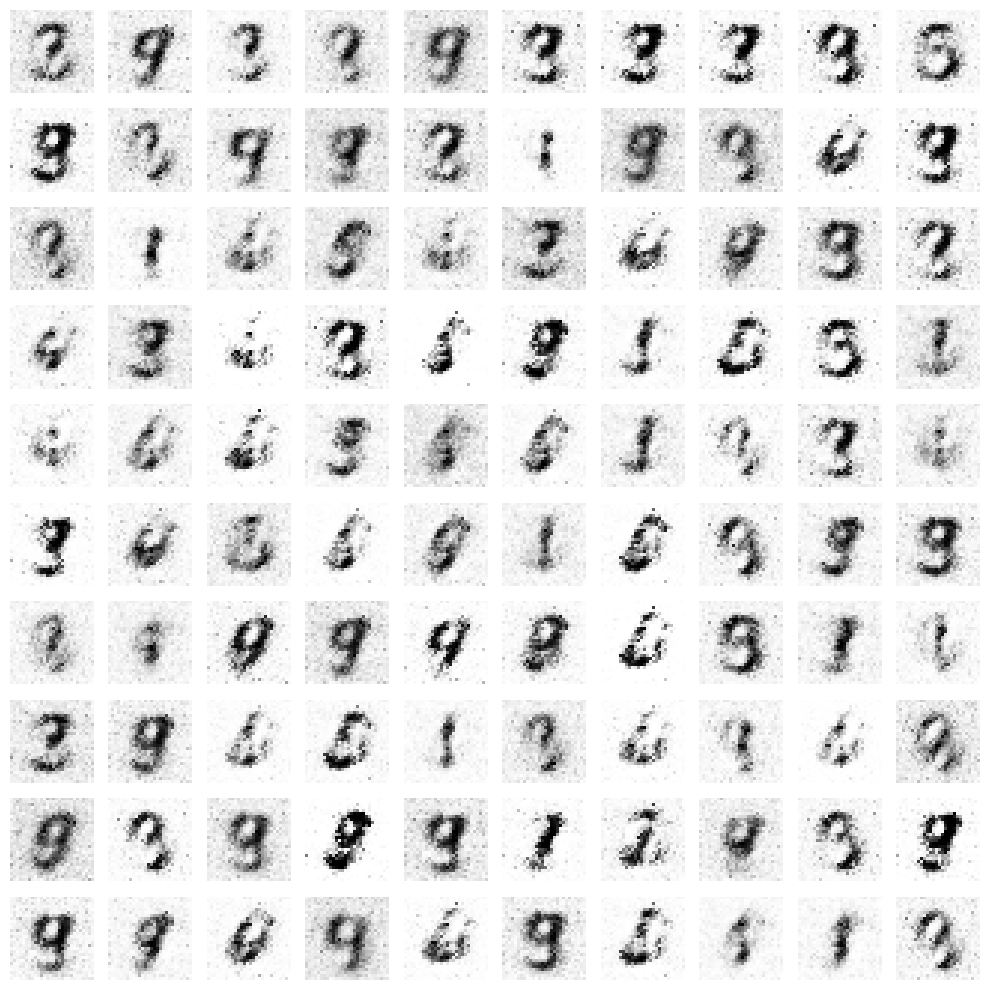

In [13]:
train()

  0%|          | 0/468 [00:00<?, ?it/s]

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 784)              

  0%|          | 2/468 [00:00<00:24, 18.76it/s]

--------------- Epoch 2 ---------------


  0%|          | 2/468 [00:00<00:26, 17.86it/s]

--------------- Epoch 3 ---------------


  0%|          | 2/468 [00:00<00:34, 13.67it/s]

--------------- Epoch 4 ---------------


  0%|          | 2/468 [00:00<00:29, 15.97it/s]

--------------- Epoch 5 ---------------


  0%|          | 2/468 [00:00<00:31, 14.82it/s]

--------------- Epoch 6 ---------------


  0%|          | 2/468 [00:00<00:33, 14.02it/s]

--------------- Epoch 7 ---------------


  0%|          | 2/468 [00:00<00:32, 14.44it/s]

--------------- Epoch 8 ---------------


  0%|          | 2/468 [00:00<00:30, 15.52it/s]

--------------- Epoch 9 ---------------


  0%|          | 2/468 [00:00<00:34, 13.53it/s]

--------------- Epoch 10 ---------------


100%|██████████| 468/468 [00:32<00:00, 14.47it/s]


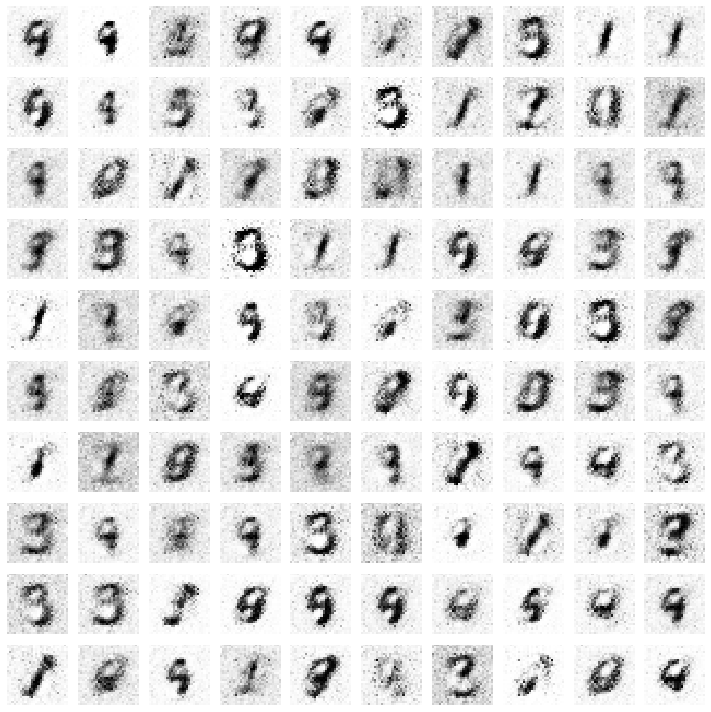

In [ ]:
train(epochs=10)

In [19]:
from tensorflow.keras.models import load_model


generator = load_model('/content/generator.h5')

import numpy as np
n=100
noise = np.random.normal(0, 1, size=[n, random_dim])
# random_noise = np.random.normal(0, 1, (number_of_samples, latent_dim))
generated_images = generator.predict(noise)

4/4 [==============================] - 0s 5ms/step


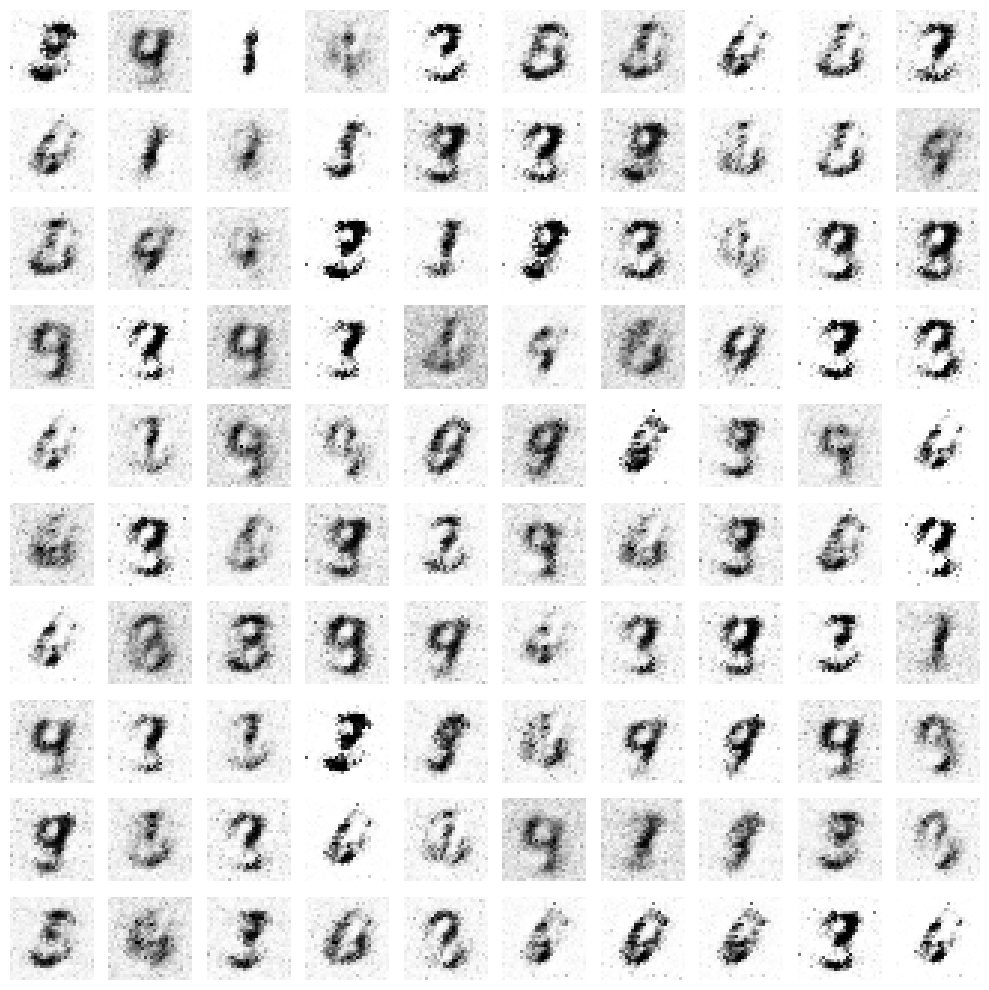

In [20]:
import matplotlib.pyplot as plt
generated_images = generated_images.reshape(n, 28, 28)

plt.figure(figsize=(10,10))
for i in range(generated_images.shape[0]):
    plt.subplot(10, 10, i+1)
    plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
    plt.axis('off')
plt.tight_layout()